# Implementation of a three hidden layer neural network for multi-class classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(1337)

# Dataset Generation

In [2]:
num_rows = 1000
num_features = 4
num_classes = 5

class_centers = np.random.randn(num_classes, num_features)
labels = np.random.randint(0, num_classes, size=num_rows)
features = class_centers[labels] + np.random.randn(num_rows, num_features)

feature_columns = [f'feature_{i+1}' for i in range(num_features)]
df = pd.DataFrame(features, columns=feature_columns)

df['class'] = labels

# save
df.to_csv('dataset.csv', index=False)

In [3]:
# df = pd.read_csv('dataset.csv')
df.head()

,feature_1,feature_2,feature_3,feature_4,class
0,0.205578,-1.813112,-1.123159,1.340638,1
1,0.883037,0.072353,0.070816,-3.067348,4
2,-1.259508,-1.507080,1.633568,-1.172304,4
3,0.272367,-0.260505,2.183088,-1.490775,4
4,2.348281,-1.767244,0.826925,-1.355650,2


In [4]:
X = df.to_numpy()[:,:-1]
Y = df.to_numpy(dtype=np.int8)[:,-1]

In [5]:
# one hot encoding
tmp = np.zeros((Y.size, Y.max()+1), dtype=np.int8)
tmp[np.arange(Y.size), Y] = 1
Y = tmp
# print(Y[0])

## Activation function formulas:
**ReLU (Rectified Linear Unit):**

$$
\text{ReLU}(x) = \max(0, x)
$$

**Softmax:**

Given a vector $ \mathbf{z} = [z_1, z_2, \dots, z_n]$:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$


In [6]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 4
        # more hidden units per layer
        hiddenLayerNeurons_1 = 16
        hiddenLayerNeurons_2 = 8
        hiddenLayerNeurons_3 = 8
        outLayerNeurons = 5 # added more units to the output layer    

        self.learning_rate = 0.001

        # added 2 more hidden layers
        self.W_HI_1 = np.random.randn(inputLayerNeurons, hiddenLayerNeurons_1)
        self.W_HI_2 = np.random.randn(hiddenLayerNeurons_1, hiddenLayerNeurons_2)
        self.W_HI_3 = np.random.randn(hiddenLayerNeurons_2, hiddenLayerNeurons_3)
        self.W_OH = np.random.randn(hiddenLayerNeurons_3, outLayerNeurons)

    # we will use softmax for multi class classification
    def softmax(self, x, der=False):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    # relu as the activation function for inner layers
    def relu(self, x, der=False):
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)
        
    def feedForward(self, X):
        hidden_input_1 = np.dot(X, self.W_HI_1)
        self.hidden_output_1 = self.relu(hidden_input_1)
        
        hidden_input_2 = np.dot(self.hidden_output_1, self.W_HI_2)
        self.hidden_output_2 = self.relu(hidden_input_2)

        hidden_input_3 = np.dot(self.hidden_output_2, self.W_HI_3)
        self.hidden_output_3 = self.relu(hidden_input_3)
        
        output_input = np.dot(self.hidden_output_3, self.W_OH)
        pred = self.softmax(output_input)
        
        return pred
        
    def backPropagation(self, X, Y, pred):
        output_delta = (pred - Y) / X.shape[0]
        
        hidden_error_3 = output_delta.dot(self.W_OH.T)
        hidden_delta_3 = hidden_error_3 * self.relu(self.hidden_output_3, der=True)
        
        hidden_error_2 = hidden_delta_3.dot(self.W_HI_3.T)
        hidden_delta_2 = hidden_error_2 * self.relu(self.hidden_output_2, der=True)
        
        hidden_error_1 = hidden_delta_2.dot(self.W_HI_2.T)
        hidden_delta_1 = hidden_error_1 * self.relu(self.hidden_output_1, der=True)
        
        self.W_HI_1 -= self.learning_rate * X.T.dot(hidden_delta_1)
        self.W_HI_2 -= self.learning_rate * self.hidden_output_1.T.dot(hidden_delta_2)
        self.W_HI_3 -= self.learning_rate * self.hidden_output_2.T.dot(hidden_delta_3)
        self.W_OH -= self.learning_rate * self.hidden_output_3.T.dot(output_delta)
        
    def train(self, X, Y, train=True):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

# Training, Validation and Testing split

In [7]:
train_count = 800
val_count = 100
test_count = 100

X_train = X[:train_count]
Y_train = Y[:train_count]
X_val = X[train_count:train_count+val_count]
Y_val = Y[train_count:train_count+val_count]
X_test = X[train_count+val_count:]
Y_test = Y[train_count+val_count:]

### Cross-Entropy Loss:

For a binary classification problem, the cross-entropy loss between the true label $ y $ and the predicted probability $ \hat{y} $ is:

$$
L(y, \hat{y}) = - \left[ y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right]
$$

For a multi-class classification problem, the cross-entropy loss for a vector of true labels $ \mathbf{y} = [y_1, y_2, \dots, y_n] $ and predicted probabilities $ \hat{\mathbf{y}} = [\hat{y}_1, \hat{y}_2, \dots, \hat{y}_n] $ is:

$$
L(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{i=1}^n y_i \log(\hat{y}_i)
$$


In [8]:
# cross entropy is suited for multi class classification loss
def cross_entropy_loss(Y, pred):
    return -np.sum(Y * np.log(pred + 1e-9)) / Y.shape[0]

In [9]:
# train
NN = NeuralNetwork()
epochs = 30_000

err_train = []
err_val = []

bar = tqdm(range(epochs))

for i in bar:
    NN.train(X_train, Y_train)
    loss_train = cross_entropy_loss(Y_train, NN.feedForward(X_train))
    err_train.append(loss_train)

    loss_val = cross_entropy_loss(Y_val, NN.feedForward(X_val))
    err_val.append(loss_val)

    # if i % 1000 == 0:
    #     print(f"[{i}] train loss: {loss_train}, test loss: {loss_test}")

    bar.set_postfix(train_loss=loss_train, val_loss=loss_val)

100%|██████████| 30000/30000 [01:22<00:00, 362.32it/s, train_loss=0.672, val_loss=0.734]


# Results and Analysis

Text(0, 0.5, 'Loss')

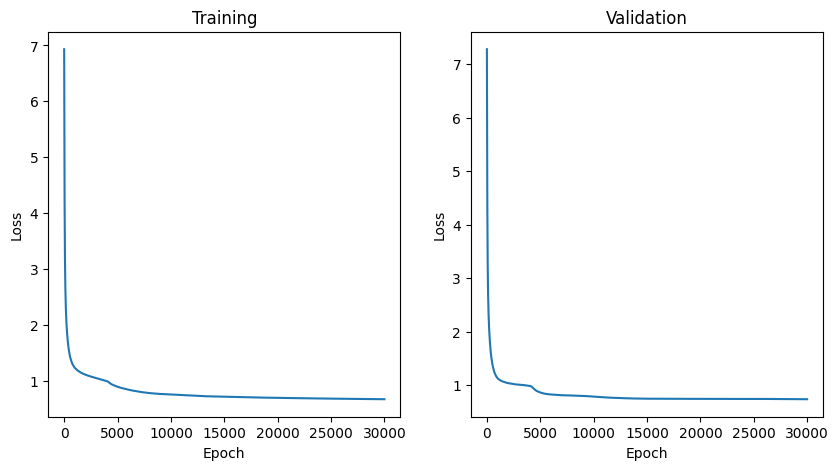

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(err_train)
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(err_val)
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [11]:
# test
test_loss = cross_entropy_loss(Y_test, NN.feedForward(X_test))

In [12]:
print('test error:', test_loss)

test error: 0.8495289444315258


# Discussion

To improve model performance and address overfitting, we adjusted the learning rate accordingly. We increased the number of hidden layers from one to three to enhance the model's capacity to capture complex patterns in the data. The dataset used for training consists of `4` input features and `5` distinct class labels. To handle multi class classification, we applied the `softmax` activation function in the output layer. We also use the `cross entropy` loss function, which is well necessary for multi class classification tasks.

After running the model for `30000` epochs we got a `training loss` = `0.677`, `validation loss` = `0.738` and `testing loss` = `0.849`. 

# Conclusion

This model performs decently on the synthetic dataset. The main challenge is choosing the right activation functions and selecting the appropriate loss function for the task. The model could be improved by adding more depth and allowing it to train for a longer duration.